In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.signal import savgol_filter, find_peaks

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
U0_LIST     = np.linspace(0.01,0.05,CPU_CNT,endpoint=False)
N_VOLT      = 50000
TIME_STEP   = 1e-12
PLOT_NORM   = Normalize(vmin=1000*U0_LIST[0], vmax=1000*U0_LIST[-1])
CMAP        = plt.get_cmap('cividis')
N_NP        = 1
# FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
FOLDER      = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
FOLDER      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/DC/size_volt/"

### SET RC Time Constant

In [418]:
topo    = {"Nx" : 1, "Ny" : 1, "electrode_type" : ['constant','constant']}
sim_c   = Simulation(topo)
tau_t   = 25*sim_c.get_capacitance_matrix()[0][0]*1e6*1e-9 # in ns
kBT     = 1000 * sim_c.KB_AJ_PER_K * 0.1 / sim_c.ELE_CHARGE_A_C
print(f"Tau_RC = {tau_t}")

Tau_RC = 0.23628021769320412


### Load Data + Output Response Curves

In [419]:
t   = np.arange(N_VOLT) * TIME_STEP
y   = np.array([pd.read_csv(f"{FOLDER}set_{V:.5f}.csv")['Observable'].values for V in U0_LIST]).T
y   = np.vstack([np.zeros(len(U0_LIST)),y])
y_e = np.array([pd.read_csv(f"{FOLDER}set_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T
y_e = np.vstack([np.zeros(len(U0_LIST)),y_e])
q   = [((pd.read_csv(f"{FOLDER}mean_state_set_{V:.5f}.csv").iloc[:,2].values*sim_c.get_capacitance_matrix())/sim_c.ELE_CHARGE_A_C).flatten() for V in U0_LIST]
I   = np.array([(pd.read_csv(f"{FOLDER}net_currents_set_{V:.5f}.csv")/sim_c.ELE_CHARGE_A_C).values for V in U0_LIST])
# I   = [((1e9)/(pd.read_csv(f"{FOLDER}net_currents_set_{V:.5f}.csv")/sim_c.ELE_CHARGE_A_C)).values for V in U0_LIST]
# I   = [((1e9)/(pd.read_csv(f"{FOLDER}net_currents_set_{V:.5f}.csv")/sim_c.ELE_CHARGE_A_C)).values.flatten() for V in U0_LIST]

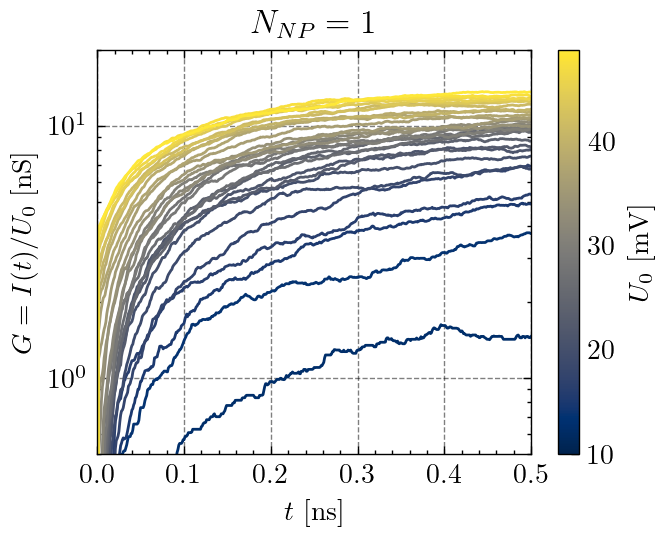

In [420]:
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()*1e9
    y_copy  = (np.round(y[:,i].copy()*1e-9,6))/V
    ax.plot(t_copy, y_copy, color=CMAP(PLOT_NORM(V*1000)))
    
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G = I(t)/U_0$ [nS]")
_ = ax.set_xlim(0.0, 500*TIME_STEP*1e9)
_ = ax.set_ylim(5e-1, 2e1)
_ = ax.set_title("$N_{NP} = 1$")
ax.set_yscale('log')
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/png/relaxation/N={N_NP}_N={N_NP}_G_vs_t.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/N={N_NP}_N={N_NP}_G_vs_t.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/N={N_NP}_N={N_NP}_G_vs_t.svg", transparent=True)

## Model-free Time Constant

In [421]:
def compute_tau_model_free(t, y, sat_points=1000, peak_fraction=0.995):
    sat_mean    = np.median(y[-sat_points:])
    idx_peak    = np.where(y >= peak_fraction * sat_mean)[0][0]
    t_plot      = t[:idx_peak]
    y_plot      = y[:idx_peak]
    f           = (sat_mean - y_plot) / sat_mean
    norm        = np.trapz(f, x=t_plot)
    if norm <= 0:
        return np.nan
    tau = np.trapz(t_plot * f, x=t_plot) / norm
    return tau

def bootstrap_tau(t, y, y_e, n_boot=2000, sat_points=1000, peak_fraction=0.995):
    sigma   = y_e.copy() / 1.96
    taus    = np.empty(n_boot, dtype=float)
    for k in range(n_boot):
        yb      = y + np.random.normal(loc=0.0, scale=sigma)
        taus[k] = compute_tau_model_free(t, yb, sat_points=sat_points, peak_fraction=peak_fraction)
    taus    = taus[~np.isnan(taus)]
    return taus

### Charge State

/tmp/ipykernel_16939/339331095.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm        = np.trapz(f, x=t_plot)
/tmp/ipykernel_16939/339331095.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tau = np.trapz(t_plot * f, x=t_plot) / norm
/tmp/ipykernel_16939/3374041669.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = ax.legend()


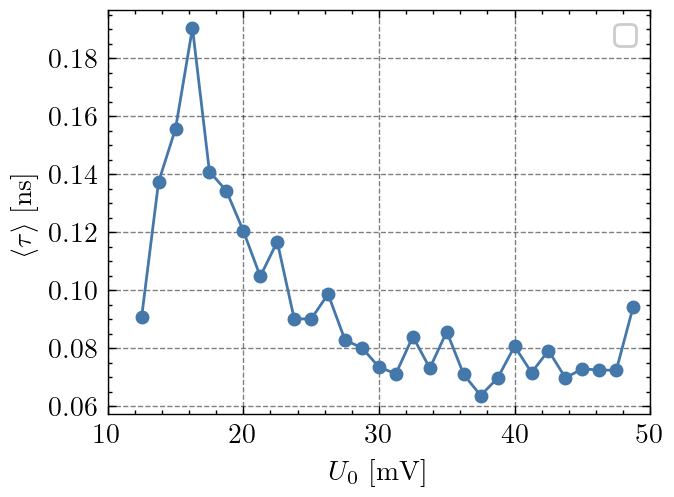

In [422]:
skip        = 0
sat_points  = 1000
peak_frac   = 0.9
taus        = []
for i in range(skip, len(U0_LIST)):
    t_copy  = t.copy()*1e9
    y_copy  = q[i]

    tau = compute_tau_model_free(t_copy, y_copy, sat_points, peak_frac)
    taus.append(tau)

V_write = np.array(U0_LIST[skip:])*1000
fig, ax = plt.subplots(dpi=200)
_ = ax.plot(V_write, taus, marker='o', ms=4)
# _ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
# _ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\langle\\tau\\rangle$ [ns]")
_ = ax.set_xlim(10, 50)

# fig.savefig(f"plots/png/relaxation/SET_tau_vs_U.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/SET_tau_vs_U.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/SET_tau_vs_U.svg", transparent=True)

### Output electric Current

In [423]:
skip        = 2
sat_points  = 1000
peak_fracs  = np.linspace(0.5,1.0,21)
n_boot      = 100
tau_results = {}
for peak_frac in peak_fracs:
    taus = []
    for i, V in enumerate(U0_LIST[skip:]):
        # Copy data
        t_copy      = t.copy()*1e9
        y_copy      = (y[:,i+skip].copy()*1e-9)/V
        y_e_copy    = (y_e[:,i+skip].copy()*1e-9)/V

        # Bootstrap tau values
        tau = bootstrap_tau(t_copy, y_copy, y_e_copy, n_boot, sat_points, peak_frac)
        taus.append(tau)
    taus = np.array(taus)
    tau_results[peak_frac] = taus

/tmp/ipykernel_16939/339331095.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm        = np.trapz(f, x=t_plot)
/tmp/ipykernel_16939/339331095.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tau = np.trapz(t_plot * f, x=t_plot) / norm


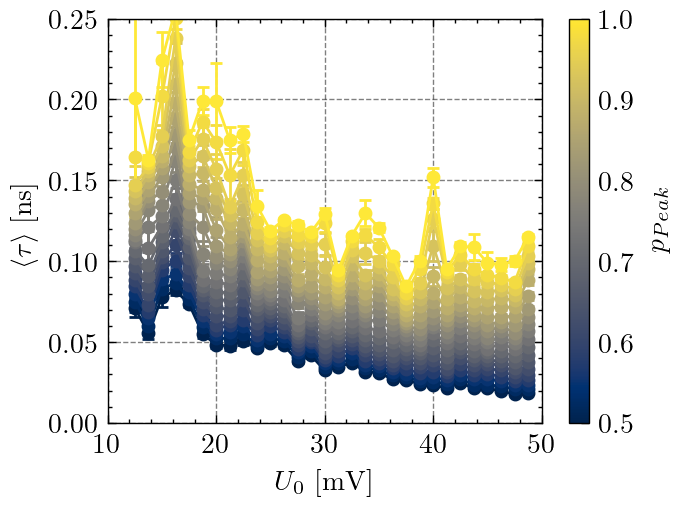

In [477]:
PLOT_NORM2  = Normalize(vmin=peak_fracs[0], vmax=peak_fracs[-1])
fig, ax     = plt.subplots(dpi=200)
for peak_frac in peak_fracs:
    taus        = tau_results[peak_frac]
    V_write     = np.array(U0_LIST[skip:])*1000
    tau_median  = np.median(np.array(taus), axis=1)
    tau_mean    = np.mean(np.array(taus), axis=1)
    tau_std     = np.std(np.array(taus), axis=1)
    tau_ci_u    = np.quantile(np.array(taus), 0.975, axis=1)
    tau_ci_l    = np.quantile(np.array(taus), 0.025, axis=1)
    _           = ax.errorbar(V_write, tau_mean, tau_std, marker='o', ms=4, capsize=2, color=CMAP(PLOT_NORM2(peak_frac)))
    # _ = ax.errorbar(V_write, tau_median, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
# _ = ax.hlines(tau_t, 10, 50, colors='grey', label='$\\tau_{SET} = R \cdot C$', ls='--')
# _ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\langle\\tau\\rangle$ [ns]")
_ = ax.set_xlim(10, 50)
_ = ax.set_ylim(0, 0.25)
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM2)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$p_{Peak}$")

fig.savefig(f"plots/png/relaxation/SET_current_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_current_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_current_tau_vs_U.svg", transparent=True)

In [497]:
tau_median

array([0.16948908, 0.16342154, 0.2320682 , 0.25676495, 0.1772045 ,
       0.20152511, 0.19478276, 0.17595996, 0.18014007, 0.13189212,
       0.11963906, 0.12595431, 0.12259179, 0.11817284, 0.12972527,
       0.09463638, 0.11592699, 0.1285816 , 0.12132825, 0.10321298,
       0.08303142, 0.1001971 , 0.15397288, 0.09501093, 0.10854556,
       0.10400067, 0.09712016, 0.09755959, 0.10070206, 0.11550119])

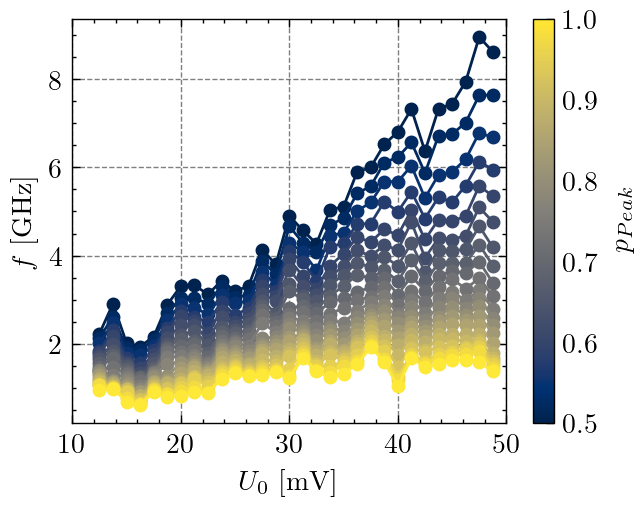

In [500]:
PLOT_NORM2  = Normalize(vmin=peak_fracs[0], vmax=peak_fracs[-1])
fig, ax     = plt.subplots(dpi=200)
for peak_frac in peak_fracs:
    taus        = tau_results[peak_frac]
    V_write     = np.array(U0_LIST[skip:])*1000
    tau_median  = np.median(np.array(taus), axis=1)
    _           = ax.plot(V_write, 1/(2*np.pi*tau_median), marker='o', ms=4, color=CMAP(PLOT_NORM2(peak_frac)))
    # _ = ax.errorbar(V_write, tau_median, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
# _ = ax.hlines(tau_t, 10, 50, colors='grey', label='$\\tau_{SET} = R \cdot C$', ls='--')
# _ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$f$ [GHz]")
_ = ax.set_xlim(10, 50)
# _ = ax.set_ylim(0, 0.25)
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM2)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$p_{Peak}$")

fig.savefig(f"plots/png/relaxation/SET_current_f0_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_current_f0_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_current_f0_vs_U.svg", transparent=True)

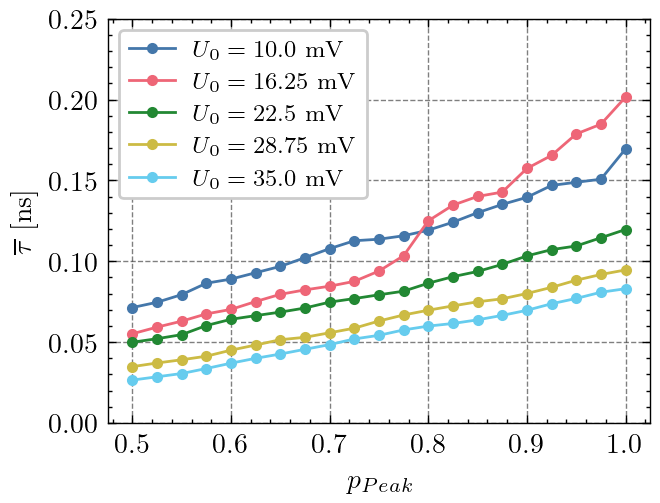

In [478]:
peak_frac   = 0.7
fig         = plt.figure(dpi=200)
ax          = fig.add_subplot()
for i in [0,5,10,15,20]:
    avg = np.array([np.median(tau_results[p_frac][i]) for p_frac in peak_fracs])
    ci1 = np.array([np.quantile(tau_results[p_frac][i],0.025) for p_frac in peak_fracs])
    ci2 = np.array([np.quantile(tau_results[p_frac][i],0.975) for p_frac in peak_fracs])
    ax.plot(peak_fracs, avg, marker='.', label=f'$U_0 = {np.round(U0_LIST[i]*1000,2)}$ mV')
ax.set_ylabel("$\\overline{\\tau}$ [ns]")
ax.set_xlabel("$p_{Peak}$")
ax.legend(fontsize='small')
_ = ax.set_ylim(0, 0.25)

fig.savefig(f"plots/png/relaxation/SET_current_tau_vs_p_peak.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_current_tau_vs_p_peak.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_current_tau_vs_p_peak.svg", transparent=True)

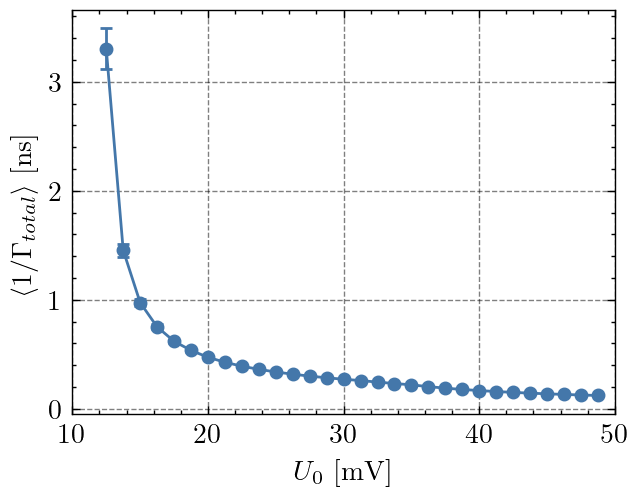

In [501]:
skip        = 2
idx         = -1
V_write     = np.array(U0_LIST[skip:])*1000
tau         = (1e9/np.sum(I, axis=2))[skip:,:]
tau_median  = np.median(tau, axis=1)
tau_mean    = np.mean(tau, axis=1)
tau_std     = np.std(tau, axis=1)
tau_ci_u    = np.quantile(tau, 0.975, axis=1)
tau_ci_l    = np.quantile(tau, 0.025, axis=1)

fig, ax = plt.subplots(dpi=200)
# _ = ax.errorbar(V_write, tau_median, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
_ = ax.errorbar(V_write, tau_mean, tau_std, marker='o', ms=4, capsize=2)
# _ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
# _ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\langle 1/\\Gamma_{total} \\rangle$ [ns]")
_ = ax.set_xlim(10, 50)
# _ = ax.set_ylim(0.0,1.0)

fig.savefig(f"plots/png/relaxation/SET_current_gamma_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_current_gamma_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_current_gamma_tau_vs_U.svg", transparent=True)

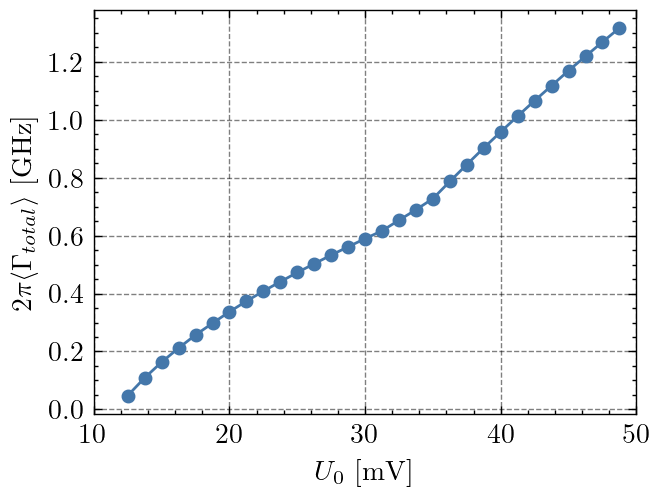

In [504]:
skip        = 2
idx         = -1
V_write     = np.array(U0_LIST[skip:])*1000
tau         = (1e9/np.sum(I, axis=2))[skip:,:]
tau_median  = np.median(tau, axis=1)
tau_mean    = np.mean(tau, axis=1)
tau_std     = np.std(tau, axis=1)
tau_ci_u    = np.quantile(tau, 0.975, axis=1)
tau_ci_l    = np.quantile(tau, 0.025, axis=1)

fig, ax = plt.subplots(dpi=200)
# _ = ax.errorbar(V_write, tau_median, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
_ = ax.plot(V_write, 1/(2*np.pi*tau_mean), marker='o', ms=4)
# _ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
# _ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$2\\pi\\langle \\Gamma_{total} \\rangle$ [GHz]")
_ = ax.set_xlim(10, 50)
# _ = ax.set_ylim(0.0,1.0)

fig.savefig(f"plots/png/relaxation/SET_current_gamma_f_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_current_gamma_f_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_current_gamma_f_vs_U.svg", transparent=True)

/tmp/ipykernel_16939/1165540538.py:4: RuntimeWarning: divide by zero encountered in divide
  tau         = 1e9/I
/tmp/ipykernel_16939/1165540538.py:4: RuntimeWarning: overflow encountered in divide
  tau         = 1e9/I


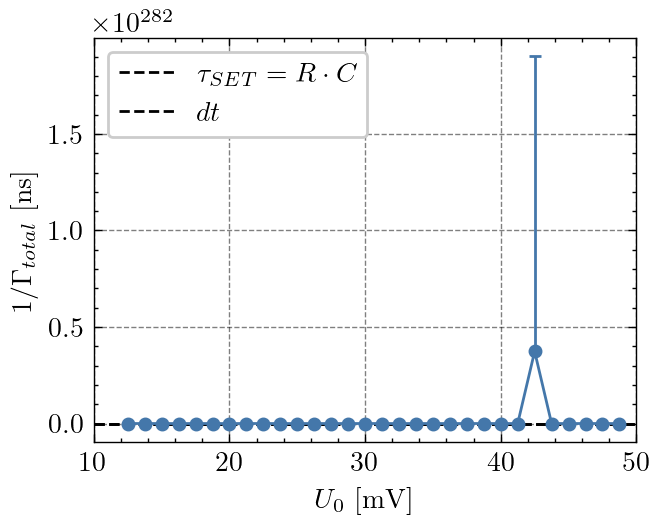

In [ ]:
skip        = 2
idx         = -1
V_write     = np.array(U0_LIST[skip:])*1000
tau         = 1e9/I
tau         = np.array([tau[i].flatten() for i in range(len(U0_LIST))])
tau         = [tau[i][~np.isinf(tau[i])] for i in range(len(U0_LIST))]
tau_mean    = [np.mean(tau[i]) for i in range(skip,len(U0_LIST))]
tau_ci_u    = [np.quantile(tau[i],0.975) for i in range(skip,len(U0_LIST))]
tau_ci_l    = [np.quantile(tau[i],0.025) for i in range(skip,len(U0_LIST))]

fig, ax = plt.subplots(dpi=200)
_ = ax.errorbar(V_write, tau_mean, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\Gamma_{total}$ [ns]")
_ = ax.set_xlim(10, 50)
# _ = ax.set_ylim(0.0009,1e5)
# _ = ax.set_yscale('log')

# fig.savefig(f"plots/png/relaxation/SET_tau_vs_U.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/SET_tau_vs_U.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/SET_tau_vs_U.svg", transparent=True)